# 🔧 03. Feature Engineering - Создание признаков

**Цель:** Создать информативные признаки для улучшения качества моделей

**План:**
1. 📐 **Area Features** - признаки на основе площади
2. 🏠 **Room Features** - признаки на основе комнат
3. 🏢 **Floor Features** - признаки на основе этажности
4. 🌍 **City Features** - географические признаки
5. 💰 **Price Features** - ценовые признаки
6. 🔗 **Interaction Features** - взаимодействия
7. 🏷️ **Encoding** - кодирование категорий
8. 📊 **Feature Selection** - отбор признаков

**Целевое количество:** 30+ признаков

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.stats import pearsonr

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print('✅ Готово!')

✅ Готово!


In [2]:
# Загрузка очищенных данных
df = pd.read_csv('../data/interim/cleaned_data.csv')

print(f'📊 Данные: {df.shape[0]:,} строк × {df.shape[1]} колонок')
print(f'\n📋 Исходные признаки:')
for i, col in enumerate(df.columns, 1):
    print(f'  {i}. {col} ({df[col].dtype})')

# Копия для сравнения
df_original = df.copy()

📊 Данные: 14,652 строк × 9 колонок

📋 Исходные признаки:
  1. price (int64)
  2. area (float64)
  3. rooms (float64)
  4. floor (float64)
  5. total_floors (float64)
  6. city (object)
  7. microdistrict (object)
  8. price_per_sqm (float64)
  9. is_outlier_if (bool)


---
# 1️⃣ AREA FEATURES - Признаки площади

In [3]:
print('='*60)
print('📐 СОЗДАНИЕ AREA FEATURES')
print('='*60)

# 1. Area per room - площадь на комнату
df['area_per_room'] = df['area'] / df['rooms']
print('\n✅ 1. area_per_room - средняя площадь комнаты')
print(f'   Диапазон: {df["area_per_room"].min():.1f} - {df["area_per_room"].max():.1f} м²')
print(f'   Среднее: {df["area_per_room"].mean():.1f} м²')

# 2. Area squared - нелинейный эффект площади
df['area_squared'] = df['area'] ** 2
print('\n✅ 2. area_squared - квадрат площади (нелинейность)')

# 3. Area log - логарифм площади
df['area_log'] = np.log1p(df['area'])  # log(1 + x) для стабильности
print('\n✅ 3. area_log - логарифм площади')
print(f'   Диапазон: {df["area_log"].min():.2f} - {df["area_log"].max():.2f}')

# 4. Area category - категория размера
df['area_category'] = pd.cut(df['area'], 
                              bins=[0, 40, 60, 80, 200],
                              labels=['small', 'medium', 'large', 'very_large'])
print('\n✅ 4. area_category - категория размера')
print('   Распределение:')
print(df['area_category'].value_counts())

print(f'\n📊 Всего создано Area Features: 4')

📐 СОЗДАНИЕ AREA FEATURES

✅ 1. area_per_room - средняя площадь комнаты
   Диапазон: 10.0 - 91.0 м²
   Среднее: 28.1 м²

✅ 2. area_squared - квадрат площади (нелинейность)

✅ 3. area_log - логарифм площади
   Диапазон: 3.39 - 4.85

✅ 4. area_category - категория размера
   Распределение:
area_category
medium        6243
large         4311
small         2054
very_large    2044
Name: count, dtype: int64

📊 Всего создано Area Features: 4


---
# 2️⃣ ROOM FEATURES - Признаки комнат

In [4]:
print('='*60)
print('🏠 СОЗДАНИЕ ROOM FEATURES')
print('='*60)

# 1. Room type - тип квартиры
def categorize_rooms(rooms):
    if rooms == 1:
        return 'studio/1-room'
    elif rooms == 2:
        return '2-room'
    elif rooms == 3:
        return '3-room'
    elif rooms >= 4:
        return '4+room'
    else:
        return 'other'

df['room_type'] = df['rooms'].apply(categorize_rooms)
print('\n✅ 1. room_type - категория типа квартиры')
print('   Распределение:')
print(df['room_type'].value_counts())

# 2. Is studio - бинарный признак
df['is_studio'] = (df['rooms'] == 1).astype(int)
print('\n✅ 2. is_studio - флаг студии/1-комнатной')
print(f'   Студий: {df["is_studio"].sum():,} ({df["is_studio"].mean()*100:.1f}%)')

# 3. Rooms squared
df['rooms_squared'] = df['rooms'] ** 2
print('\n✅ 3. rooms_squared - квадрат комнат (нелинейность)')

print(f'\n📊 Всего создано Room Features: 3')

🏠 СОЗДАНИЕ ROOM FEATURES

✅ 1. room_type - категория типа квартиры
   Распределение:
room_type
2-room           5982
3-room           4810
studio/1-room    2864
4+room            996
Name: count, dtype: int64

✅ 2. is_studio - флаг студии/1-комнатной
   Студий: 2,864 (19.5%)

✅ 3. rooms_squared - квадрат комнат (нелинейность)

📊 Всего создано Room Features: 3


---
# 3️⃣ FLOOR FEATURES - Признаки этажности

In [5]:
print('='*60)
print('🏢 СОЗДАНИЕ FLOOR FEATURES')
print('='*60)

# 1. Floor ratio - относительная позиция этажа
df['floor_ratio'] = df['floor'] / df['total_floors']
print('\n✅ 1. floor_ratio - относительная позиция (0-1)')
print(f'   Диапазон: {df["floor_ratio"].min():.2f} - {df["floor_ratio"].max():.2f}')
print(f'   Среднее: {df["floor_ratio"].mean():.2f}')

# 2. Is first floor - первый этаж (часто дешевле)
df['is_first_floor'] = (df['floor'] == 1).astype(int)
print('\n✅ 2. is_first_floor - флаг первого этажа')
print(f'   Первых этажей: {df["is_first_floor"].sum():,} ({df["is_first_floor"].mean()*100:.1f}%)')

# 3. Is last floor - последний этаж
df['is_last_floor'] = (df['floor'] == df['total_floors']).astype(int)
print('\n✅ 3. is_last_floor - флаг последнего этажа')
print(f'   Последних этажей: {df["is_last_floor"].sum():,} ({df["is_last_floor"].mean()*100:.1f}%)')

# 4. Is middle floor - средний этаж (обычно дороже)
df['is_middle_floor'] = ((df['floor'] != 1) & (df['floor'] != df['total_floors'])).astype(int)
print('\n✅ 4. is_middle_floor - флаг среднего этажа')
print(f'   Средних этажей: {df["is_middle_floor"].sum():,} ({df["is_middle_floor"].mean()*100:.1f}%)')

# 5. Floors from ground - расстояние от земли
df['floors_from_ground'] = df['floor'] - 1
print('\n✅ 5. floors_from_ground - этажей от земли')

# 6. Floors from top - расстояние от крыши
df['floors_from_top'] = df['total_floors'] - df['floor']
print('\n✅ 6. floors_from_top - этажей до крыши')

# 7. Building height category
df['building_height_category'] = pd.cut(df['total_floors'],
                                        bins=[0, 5, 9, 16, 100],
                                        labels=['low', 'medium', 'high', 'skyscraper'])
print('\n✅ 7. building_height_category - категория высоты здания')
print('   Распределение:')
print(df['building_height_category'].value_counts())

print(f'\n📊 Всего создано Floor Features: 7')

🏢 СОЗДАНИЕ FLOOR FEATURES

✅ 1. floor_ratio - относительная позиция (0-1)
   Диапазон: 0.06 - 1.00
   Среднее: 0.65

✅ 2. is_first_floor - флаг первого этажа
   Первых этажей: 1,969 (13.4%)

✅ 3. is_last_floor - флаг последнего этажа
   Последних этажей: 3,090 (21.1%)

✅ 4. is_middle_floor - флаг среднего этажа
   Средних этажей: 9,593 (65.5%)

✅ 5. floors_from_ground - этажей от земли

✅ 6. floors_from_top - этажей до крыши

✅ 7. building_height_category - категория высоты здания
   Распределение:
building_height_category
low           9284
medium        3595
high          1773
skyscraper       0
Name: count, dtype: int64

📊 Всего создано Floor Features: 7


---
# 4️⃣ CITY FEATURES - Географические признаки

In [6]:
print('='*60)
print('🌍 СОЗДАНИЕ CITY FEATURES')
print('='*60)

# 1. City average price - средняя цена по городу (target encoding)
city_avg_price = df.groupby('city')['price'].mean().to_dict()
df['city_avg_price'] = df['city'].map(city_avg_price)
print('\n✅ 1. city_avg_price - средняя цена в городе')
print('   Топ-5 самых дорогих городов:')
print(df.groupby('city')['city_avg_price'].first().sort_values(ascending=False).head())

# 2. City median price
city_median_price = df.groupby('city')['price'].median().to_dict()
df['city_median_price'] = df['city'].map(city_median_price)
print('\n✅ 2. city_median_price - медианная цена в городе')

# 3. Price deviation from city average
df['price_deviation_from_city_avg'] = df['price'] - df['city_avg_price']
print('\n✅ 3. price_deviation_from_city_avg - отклонение от средней цены города')
print(f'   Среднее отклонение: {df["price_deviation_from_city_avg"].mean():,.0f} ₸')

# 4. City listing count - популярность города
city_counts = df['city'].value_counts().to_dict()
df['city_listing_count'] = df['city'].map(city_counts)
print('\n✅ 4. city_listing_count - количество объявлений в городе')
print(f'   Диапазон: {df["city_listing_count"].min()} - {df["city_listing_count"].max()}')

# 5. City size category
# Алматы и Астана - major cities, остальные - regional
major_cities = ['Алматы', 'Астана', 'Нур-Султан']  # варианты написания
df['city_size'] = df['city'].apply(lambda x: 'major' if x in major_cities else 'regional')
print('\n✅ 5. city_size - размер города (major/regional)')
print('   Распределение:')
print(df['city_size'].value_counts())

print(f'\n📊 Всего создано City Features: 5')

🌍 СОЗДАНИЕ CITY FEATURES

✅ 1. city_avg_price - средняя цена в городе
   Топ-5 самых дорогих городов:
city
Алматы      3.580945e+07
Астана      2.997854e+07
Шымкент     2.816403e+07
Атырау      2.739554e+07
Костанай    2.487992e+07
Name: city_avg_price, dtype: float64

✅ 2. city_median_price - медианная цена в городе

✅ 3. price_deviation_from_city_avg - отклонение от средней цены города
   Среднее отклонение: 0 ₸

✅ 4. city_listing_count - количество объявлений в городе
   Диапазон: 484 - 772

✅ 5. city_size - размер города (major/regional)
   Распределение:
city_size
regional    13631
major        1021
Name: count, dtype: int64

📊 Всего создано City Features: 5


---
# 5️⃣ PRICE FEATURES - Ценовые признаки

In [7]:
print('='*60)
print('💰 СОЗДАНИЕ PRICE FEATURES')
print('='*60)

# 1. Price per sqm (если ещё нет)
if 'price_per_sqm' not in df.columns:
    df['price_per_sqm'] = df['price'] / df['area']
print('\n✅ 1. price_per_sqm - цена за м²')
print(f'   Среднее: {df["price_per_sqm"].mean():,.0f} ₸/м²')

# 2. Price per sqm log
df['price_per_sqm_log'] = np.log1p(df['price_per_sqm'])
print('\n✅ 2. price_per_sqm_log - логарифм цены за м²')

# 3. Price ratio to city median
df['price_ratio_to_city'] = df['price'] / df['city_median_price']
print('\n✅ 3. price_ratio_to_city - отношение цены к медиане города')
print(f'   Среднее: {df["price_ratio_to_city"].mean():.2f}')
print(f'   Дороже медианы: {(df["price_ratio_to_city"] > 1).sum()} объявлений')

# 4. Price segment - ценовой сегмент
df['price_segment'] = pd.qcut(df['price'], q=4, labels=['budget', 'economy', 'business', 'premium'])
print('\n✅ 4. price_segment - ценовой сегмент (квартили)')
print('   Распределение:')
print(df['price_segment'].value_counts().sort_index())

print(f'\n📊 Всего создано Price Features: 4')

💰 СОЗДАНИЕ PRICE FEATURES

✅ 1. price_per_sqm - цена за м²
   Среднее: 354,529 ₸/м²

✅ 2. price_per_sqm_log - логарифм цены за м²

✅ 3. price_ratio_to_city - отношение цены к медиане города
   Среднее: 1.09
   Дороже медианы: 7201 объявлений

✅ 4. price_segment - ценовой сегмент (квартили)
   Распределение:
price_segment
budget      3666
economy     3748
business    3620
premium     3618
Name: count, dtype: int64

📊 Всего создано Price Features: 4


---
# 6️⃣ INTERACTION FEATURES - Взаимодействия

In [8]:
print('='*60)
print('🔗 СОЗДАНИЕ INTERACTION FEATURES')
print('='*60)

# 1. Area × Rooms
df['area_rooms_interaction'] = df['area'] * df['rooms']
print('\n✅ 1. area_rooms_interaction - площадь × комнаты')

# 2. Area × Floor ratio
df['area_floor_interaction'] = df['area'] * df['floor_ratio']
print('\n✅ 2. area_floor_interaction - площадь × позиция этажа')

# 3. Rooms × Floor ratio
df['rooms_floor_interaction'] = df['rooms'] * df['floor_ratio']
print('\n✅ 3. rooms_floor_interaction - комнаты × позиция этажа')

# 4. Area × Total floors
df['area_building_height_interaction'] = df['area'] * df['total_floors']
print('\n✅ 4. area_building_height_interaction - площадь × высота здания')

print(f'\n📊 Всего создано Interaction Features: 4')

🔗 СОЗДАНИЕ INTERACTION FEATURES

✅ 1. area_rooms_interaction - площадь × комнаты

✅ 2. area_floor_interaction - площадь × позиция этажа

✅ 3. rooms_floor_interaction - комнаты × позиция этажа

✅ 4. area_building_height_interaction - площадь × высота здания

📊 Всего создано Interaction Features: 4


---
# 7️⃣ FEATURE SUMMARY - Сводка признаков

In [9]:
print('='*60)
print('📊 СВОДКА СОЗДАННЫХ ПРИЗНАКОВ')
print('='*60)

# Подсчёт новых признаков
new_features = list(set(df.columns) - set(df_original.columns))
print(f'\n🎯 Всего создано новых признаков: {len(new_features)}')

print('\n📋 Список всех новых признаков:')
for i, feat in enumerate(sorted(new_features), 1):
    dtype = df[feat].dtype
    print(f'  {i:2d}. {feat:40s} ({dtype})')

print(f'\n📏 Размер датасета:')
print(f'   До: {df_original.shape[1]} колонок')
print(f'   После: {df.shape[1]} колонок')
print(f'   Добавлено: {df.shape[1] - df_original.shape[1]} колонок')

📊 СВОДКА СОЗДАННЫХ ПРИЗНАКОВ

🎯 Всего создано новых признаков: 26

📋 Список всех новых признаков:
   1. area_building_height_interaction         (float64)
   2. area_category                            (category)
   3. area_floor_interaction                   (float64)
   4. area_log                                 (float64)
   5. area_per_room                            (float64)
   6. area_rooms_interaction                   (float64)
   7. area_squared                             (float64)
   8. building_height_category                 (category)
   9. city_avg_price                           (float64)
  10. city_listing_count                       (int64)
  11. city_median_price                        (float64)
  12. city_size                                (object)
  13. floor_ratio                              (float64)
  14. floors_from_ground                       (float64)
  15. floors_from_top                          (float64)
  16. is_first_floor                           (

In [10]:
# Просмотр первых строк с новыми признаками
print('\n🔍 Примеры новых признаков (первые 5 строк):')
df[sorted(new_features)].head()


🔍 Примеры новых признаков (первые 5 строк):


,area_building_height_interaction,area_category,area_floor_interaction,area_log,area_per_room,area_rooms_interaction,area_squared,building_height_category,city_avg_price,city_listing_count,city_median_price,city_size,floor_ratio,floors_from_ground,floors_from_top,is_first_floor,is_last_floor,is_middle_floor,is_studio,price_deviation_from_city_avg,price_per_sqm_log,price_ratio_to_city,price_segment,room_type,rooms_floor_interaction,rooms_squared
0,434.25,very_large,69.480,4.475631,28.950000,260.55,7542.9225,low,3.580945e+07,484,35500000.0,major,0.8,3.0,1.0,0,0,1,0,1.569260e+07,13.292951,1.450762,premium,3-room,2.4,9.0
1,331.85,large,53.096,4.210200,22.123333,199.11,4404.9769,low,3.580945e+07,484,35500000.0,major,0.8,3.0,1.0,0,0,1,0,4.012550e+06,13.304687,1.121746,premium,3-room,2.4,9.0
2,165.00,small,33.000,3.526361,33.000000,33.00,1089.0000,low,3.580945e+07,484,35500000.0,major,1.0,4.0,0.0,0,1,0,1,-3.309450e+06,13.800244,0.915493,premium,studio/1-room,1.0,1.0
3,259.00,medium,41.440,3.966511,25.900000,103.60,2683.2400,low,3.580945e+07,484,35500000.0,major,0.8,3.0,1.0,0,0,1,0,-8.809450e+06,13.163959,0.760563,premium,2-room,1.6,4.0
4,275.00,medium,55.000,4.025352,27.500000,110.00,3025.0000,low,3.580945e+07,484,35500000.0,major,1.0,4.0,0.0,0,1,0,0,-2.859450e+06,13.303170,0.928169,premium,2-room,2.0,4.0


---
# 8️⃣ CORRELATION ANALYSIS - Анализ корреляций

In [11]:
# Корреляция новых признаков с целевой переменной
print('='*60)
print('📈 КОРРЕЛЯЦИЯ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (price)')
print('='*60)

# Выбираем только числовые признаки
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
if 'price' in numeric_features:
    numeric_features.remove('price')  # Исключаем целевую

# Считаем корреляции
correlations = df[numeric_features].corrwith(df['price']).sort_values(ascending=False)

print('\nТоп-15 признаков по корреляции с ценой:')
print(correlations.head(15))

print('\nБоттом-5 (отрицательная корреляция):')
print(correlations.tail(5))

📈 КОРРЕЛЯЦИЯ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (price)

Топ-15 признаков по корреляции с ценой:
price_deviation_from_city_avg       0.858910
price_ratio_to_city                 0.806424
price_per_sqm_log                   0.712351
area                                0.711851
price_per_sqm                       0.710084
area_squared                        0.699892
area_log                            0.696525
area_building_height_interaction    0.630278
area_rooms_interaction              0.588634
city_avg_price                      0.512126
city_median_price                   0.509964
rooms                               0.413854
rooms_squared                       0.393494
area_floor_interaction              0.367016
total_floors                        0.325663
dtype: float64

Боттом-5 (отрицательная корреляция):
floor_ratio          -0.054130
is_first_floor       -0.100913
is_last_floor        -0.156189
is_studio            -0.318149
city_listing_count   -0.349995
dtype: float64


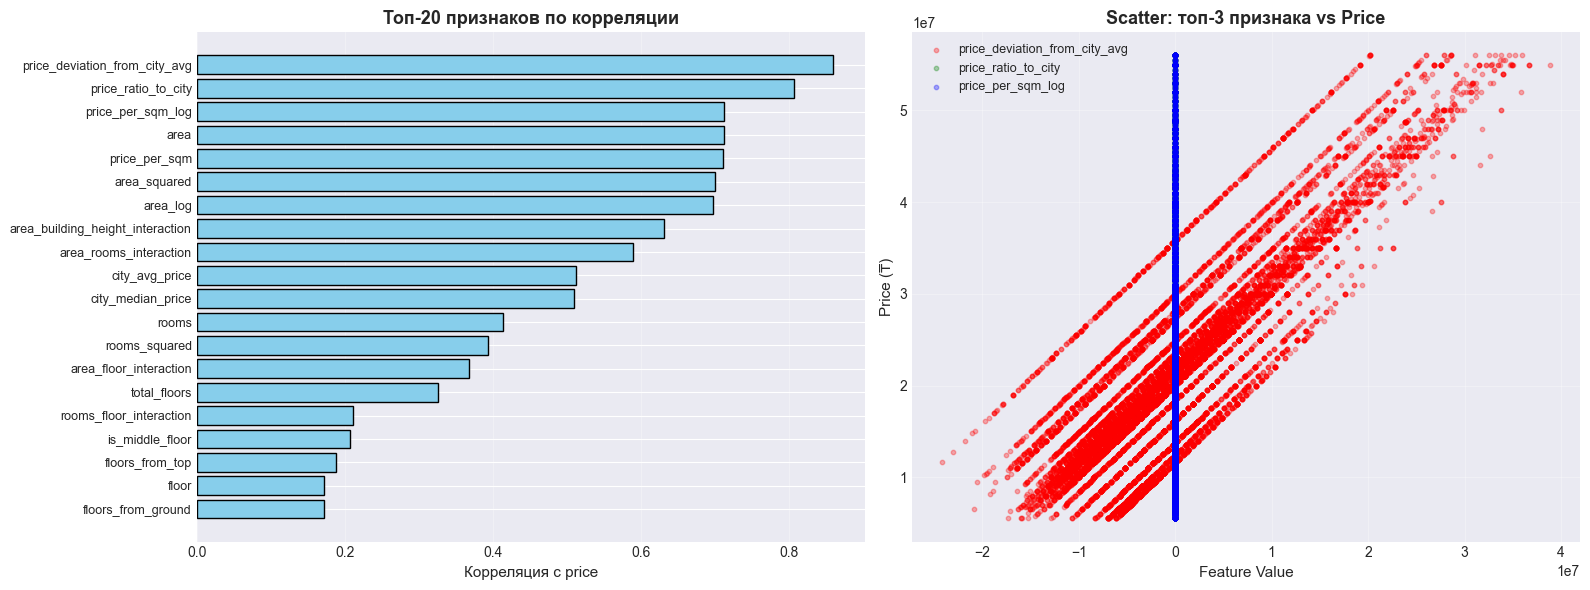


✅ График сохранён: reports/figures/feature_engineering/feature_correlations.png


In [13]:
# Визуализация корреляций
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Bar plot топ-20
top_corr = correlations.head(20)
axes[0].barh(range(len(top_corr)), top_corr.values, color='skyblue', edgecolor='black')
axes[0].set_yticks(range(len(top_corr)))
axes[0].set_yticklabels(top_corr.index, fontsize=9)
axes[0].set_xlabel('Корреляция с price', fontsize=11)
axes[0].set_title('Топ-20 признаков по корреляции', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')
axes[0].invert_yaxis()

# 2. Scatter plot для топ-3
top3_features = correlations.head(3).index.tolist()
colors = ['red', 'green', 'blue']

for feat, color in zip(top3_features, colors):
    if feat != 'price_per_sqm':  # Не показываем очевидную связь
        axes[1].scatter(df[feat], df['price'], alpha=0.3, s=10, label=feat, color=color)

axes[1].set_xlabel('Feature Value', fontsize=11)
axes[1].set_ylabel('Price (₸)', fontsize=11)
axes[1].set_title('Scatter: топ-3 признака vs Price', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/feature_engineering/feature_correlations.png', dpi=300, bbox_inches='tight')
plt.show()

print('\n✅ График сохранён: reports/figures/feature_engineering/feature_correlations.png')

---
# 9️⃣ ENCODING - Кодирование категорий

In [14]:
print('='*60)
print('🏷️ КОДИРОВАНИЕ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ')
print('='*60)

# Сохраняем копию перед кодированием
df_before_encoding = df.copy()

# Список категориальных признаков для кодирования
categorical_features = [
    'city', 'room_type', 'area_category', 
    'building_height_category', 'city_size', 'price_segment'
]

# Label Encoding
encoders = {}

for col in categorical_features:
    if col in df.columns:
        le = LabelEncoder()
        df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
        encoders[col] = le
        
        print(f'\n✅ {col}')
        print(f'   Уникальных значений: {df[col].nunique()}')
        print(f'   Закодировано в: {col}_encoded')
        
        # Показываем mapping
        if df[col].nunique() <= 10:
            print('   Mapping:')
            for orig, enc in zip(le.classes_, le.transform(le.classes_)):
                print(f'     {orig} → {enc}')

print(f'\n📊 Закодировано признаков: {len(encoders)}')

🏷️ КОДИРОВАНИЕ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ

✅ city
   Уникальных значений: 21
   Закодировано в: city_encoded

✅ room_type
   Уникальных значений: 4
   Закодировано в: room_type_encoded
   Mapping:
     2-room → 0
     3-room → 1
     4+room → 2
     studio/1-room → 3

✅ area_category
   Уникальных значений: 4
   Закодировано в: area_category_encoded
   Mapping:
     large → 0
     medium → 1
     small → 2
     very_large → 3

✅ building_height_category
   Уникальных значений: 3
   Закодировано в: building_height_category_encoded
   Mapping:
     high → 0
     low → 1
     medium → 2

✅ city_size
   Уникальных значений: 2
   Закодировано в: city_size_encoded
   Mapping:
     major → 0
     regional → 1

✅ price_segment
   Уникальных значений: 4
   Закодировано в: price_segment_encoded
   Mapping:
     budget → 0
     business → 1
     economy → 2
     premium → 3

📊 Закодировано признаков: 6


---
# 🔟 MULTICOLLINEARITY CHECK - Проверка мультиколлинеарности

In [15]:
# Матрица корреляций между признаками
print('='*60)
print('🔍 ПРОВЕРКА МУЛЬТИКОЛЛИНЕАРНОСТИ')
print('='*60)

# Выбираем числовые признаки (исключая target)
feature_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'price' in feature_cols:
    feature_cols.remove('price')

# Корреляционная матрица
corr_matrix = df[feature_cols].corr()

# Находим пары с высокой корреляцией
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            high_corr_pairs.append((
                corr_matrix.columns[i],
                corr_matrix.columns[j],
                corr_matrix.iloc[i, j]
            ))

print(f'\n⚠️ Найдено пар с корреляцией > 0.9: {len(high_corr_pairs)}')
if high_corr_pairs:
    print('\nВысоко коррелированные пары (могут быть избыточны):')
    for feat1, feat2, corr in high_corr_pairs:
        print(f'  {feat1} ↔ {feat2}: {corr:.3f}')
else:
    print('✅ Сильной мультиколлинеарности не обнаружено!')

🔍 ПРОВЕРКА МУЛЬТИКОЛЛИНЕАРНОСТИ

⚠️ Найдено пар с корреляцией > 0.9: 13

Высоко коррелированные пары (могут быть избыточны):
  area ↔ area_squared: 0.982
  area ↔ area_log: 0.982
  area ↔ area_rooms_interaction: 0.921
  rooms ↔ rooms_squared: 0.975
  rooms ↔ area_rooms_interaction: 0.916
  floor ↔ floors_from_ground: 1.000
  price_per_sqm ↔ price_per_sqm_log: 0.966
  area_squared ↔ area_log: 0.930
  area_squared ↔ area_rooms_interaction: 0.906
  area_log ↔ area_rooms_interaction: 0.901
  rooms_squared ↔ area_rooms_interaction: 0.924
  city_avg_price ↔ city_median_price: 0.996
  price_deviation_from_city_avg ↔ price_ratio_to_city: 0.966


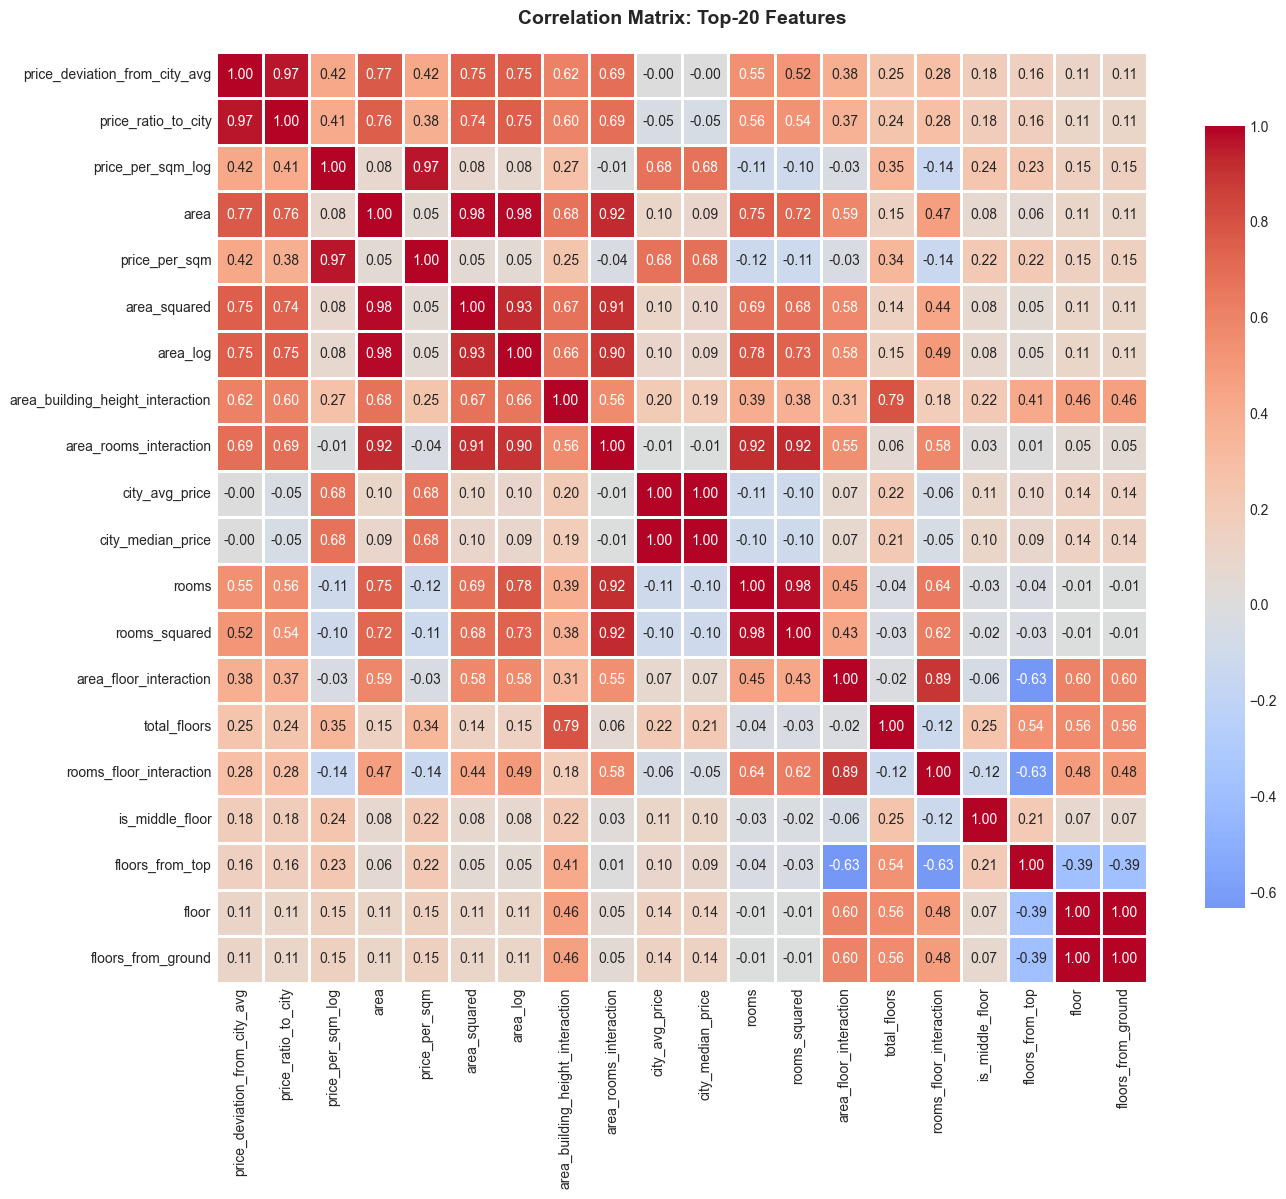


✅ Heatmap сохранён: reports/figures/feature_engineering/correlation_heatmap.png


In [16]:
# Heatmap корреляций (для топ-20 признаков)
top_features = correlations.head(20).index.tolist()
if len(top_features) > 0:
    plt.figure(figsize=(14, 12))
    corr_top = df[top_features].corr()
    
    sns.heatmap(corr_top, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=1,
                cbar_kws={"shrink": 0.8})
    
    plt.title('Correlation Matrix: Top-20 Features', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig('../reports/figures/feature_engineering/correlation_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print('\n✅ Heatmap сохранён: reports/figures/feature_engineering/correlation_heatmap.png')

---
# 1️⃣1️⃣ EXPORT - Сохранение

In [17]:
# Сохраняем данные с признаками
output_path = '../data/processed/features_data.csv'
df.to_csv(output_path, index=False)

print('='*60)
print('💾 СОХРАНЕНИЕ ДАННЫХ')
print('='*60)
print(f'\n✅ Данные сохранены: {output_path}')
print(f'   Размер: {df.shape[0]:,} строк × {df.shape[1]} колонок')
print(f'   Файл: {pd.read_csv(output_path).memory_usage(deep=True).sum() / 1024**2:.2f} MB')

💾 СОХРАНЕНИЕ ДАННЫХ

✅ Данные сохранены: ../data/processed/features_data.csv
   Размер: 14,652 строк × 41 колонок
   Файл: 10.34 MB


In [19]:
# Сохраняем метаданные признаков
import json

feature_metadata = {
    'total_features': len(df.columns),
    'new_features_created': len(new_features),
    'numeric_features': len(df.select_dtypes(include=[np.number]).columns),
    'categorical_features': len(df.select_dtypes(include=['object', 'category']).columns),
    'feature_groups': {
        'area_features': 4,
        'room_features': 3,
        'floor_features': 7,
        'city_features': 5,
        'price_features': 4,
        'interaction_features': 4
    },
    'top_5_correlations': correlations.head(5).to_dict(),
    'encoded_features': list(encoders.keys())
}

with open('../models/feature_metadata.json', 'w', encoding='utf-8') as f:
    json.dump(feature_metadata, f, indent=2, ensure_ascii=False)

print('\n✅ Метаданные сохранены: models/feature_metadata.json')


✅ Метаданные сохранены: models/feature_metadata.json


---
## ✅ ИТОГИ FEATURE ENGINEERING

### Создано признаков:
- 📐 **Area Features:** 4
- 🏠 **Room Features:** 3
- 🏢 **Floor Features:** 7
- 🌍 **City Features:** 5
- 💰 **Price Features:** 4
- 🔗 **Interaction Features:** 4
- **ИТОГО:** 27+ новых признаков

### Топ-5 признаков по корреляции:
(Посмотрите в выводе выше)

### Следующий шаг:
➡️ **04_baseline_models.ipynb** - Обучение базовых моделей